# RNN 이해 및 실습

## 1. 시계열 데이터

- 예제 시계열 만들기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xarr = np.array([100,200,300,400])
yarr = np.array([1,2,3,4])
cond = ([True,False,True,False])
np.where(cond,xarr,yarr) #cond True->xarr, False ->yarr

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5, 
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


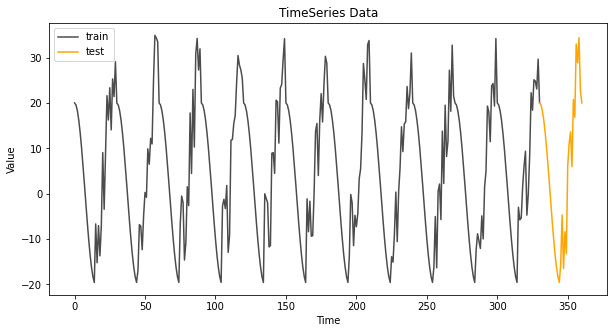

In [ ]:
plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

## 2. 시계열 데이터 전처리 : Sequence를 만들기

In [ ]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩 
    x_train, y_train = list(), list()
    
    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break
            
    return np.array(x_train), np.array(y_train)

n = 15
x_train, y_train = make_sequence(time_series, n)
x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)
print(x_train.shape)
print(y_train.shape)

(346, 15, 1)
(346, 1)


In [ ]:
from sklearn.model_selection import train_test_split   

partial_x_train = x_train[:30 * 11]
partial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', partial_x_train.shape, partial_y_train.shape) 
print('test:',x_test.shape, y_test.shape)

train: (330, 15, 1) (330, 1)
test: (16, 15, 1) (16, 1)


## 3. sequence 함수 확인하기

In [ ]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 15)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] | 16
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] | 17
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] | 18


## 4. SimpleRNN 구축

- tanh: Hyperbolic tangent 함수
- -1~1사이의 값, 출력범위가 sigmoid보다 크고, 경사가 큰 구간이 많아 sigmoid보다 빠르게 수렴하여 학습하는 특성
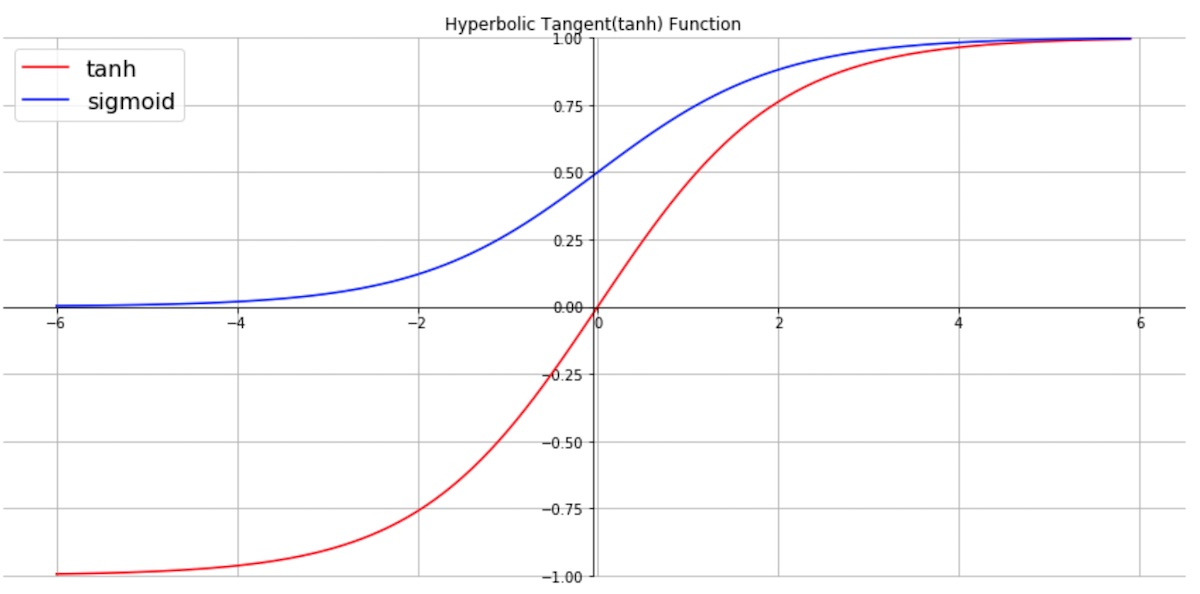

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용 
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))  
#model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))  

#rnn은 이전 단계의 가중치를 사용하며, relu 를 사용하면, 역전파 시 이전 단계의 그라디언트와 같이 사용되면 출력이 발산
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs = 30, batch_size = 1)

Epoch 1/30
346/346 [==============================] - 4s 6ms/step - loss: 168.2990
Epoch 2/30
346/346 [==============================] - 2s 6ms/step - loss: 72.5273
Epoch 3/30
346/346 [==============================] - 2s 6ms/step - loss: 45.8808
Epoch 4/30
346/346 [==============================] - 2s 6ms/step - loss: 37.0016
Epoch 5/30
346/346 [==============================] - 2s 6ms/step - loss: 31.4229
Epoch 6/30
346/346 [==============================] - 2s 6ms/step - loss: 29.3150
Epoch 7/30
346/346 [==============================] - 2s 6ms/step - loss: 26.0480
Epoch 8/30
346/346 [==============================] - 2s 6ms/step - loss: 25.4562
Epoch 9/30
346/346 [==============================] - 2s 6ms/step - loss: 24.6517
Epoch 10/30
346/346 [==============================] - 2s 6ms/step - loss: 23.3801
Epoch 11/30
346/346 [==============================] - 2s 6ms/step - loss: 22.9391
Epoch 12/30
346/346 [==============================] - 2s 6ms/step - loss: 22.2958
Epoch 13/30


## 5. 예측 VS Actual


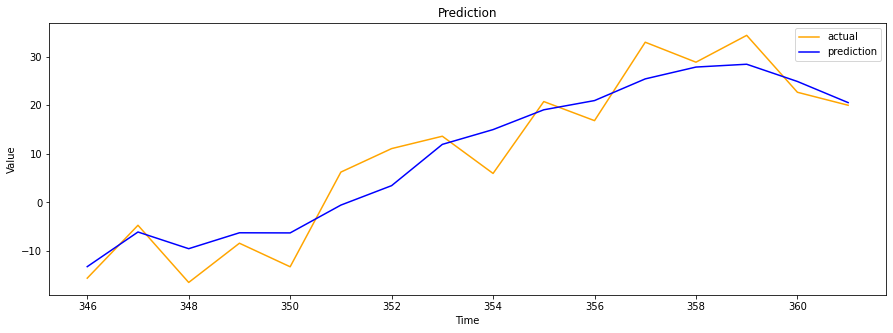

In [ ]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 6. 두번째 RNN 실습




- RNN 입력 x 데이터의 shape: (n_sample, time step, x vector의 크기) 
 - n_sample: sample의 수 
 - time step: t-n 에서 n이 몇인가를 묻는 것
 - x vector의 크기: 현재는 1개, 추후 여러 값이 입력, 여러값이 출력될 수 있음. x변수의 값 1개의 크기임
 - xvector의 크기 = yvector의 크기와 동일

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import gridspec

s = np.sin(2 * np.pi * 0.125 * np.linspace(0, 20, 50))
timestep =3 # t-3, t-2, t-1 데이터를 이용하여 t 시점의 값을 예측 
xs, ys = [], []

for i in range(timestep, len(s)):
    xs.append(np.array([s[i-j] for j in range(timestep, 0, -1)]))
    ys.append(s[i])
xs, ys = np.array(xs).reshape(len(xs), 3, 1), np.array(ys).reshape(len(ys), 1)
print(xs.shape)

(47, 3, 1)


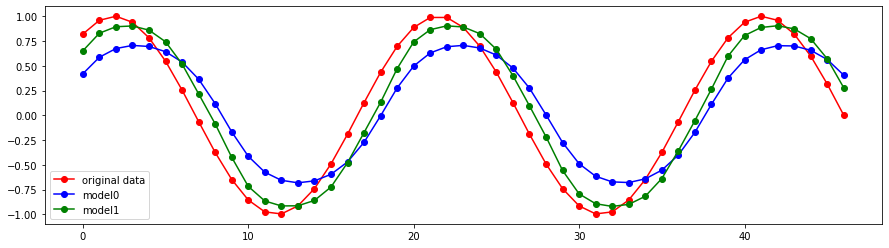

In [ ]:
## rnn 적용. 
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

## simple RNN model 
np.random.seed(0)# seed 고정
model0 = Sequential()
model0.add( SimpleRNN(units=1, input_shape=(3, 1)))
model0.compile(loss='mse', optimizer='sgd')
history0 = model0.fit(xs, ys, epochs=150, verbose=0)


model1 = Sequential()
model1.add( SimpleRNN(units=1, input_shape=(3, 1)) )
model1.add( Dense(10, activation='linear') ) 
model1.add( Dense(1, activation='linear') )
model1.compile(loss='mse', optimizer='sgd')
history1 = model1.fit(xs, ys, epochs=150, verbose=0)


## plot 
fig = plt.figure(figsize=(15, 4)) 
plt.plot(s[3:], 'ro-', label='original data') # 원래 plot, 앞의 3칸의 경우, 
plt.plot(model0.predict(xs), 'bo-', marker='o', label='model0')
plt.plot(model1.predict(xs), 'go-', marker='o', label='model1')
plt.legend()

plt.savefig('simple_rnn.svg')
plt.show()

## 7. RNN 활용 기온 예측 예제: Sequence 만들기
- 10분 간격 기록된 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측값
- 원본 데이터는 2003년부터, 예제에서 2009~2016년 사이의 데이터만 사용
- 최근 데이터(몇 일치 데이터 포인트)를 입력, 1일 후 기온 예측

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip /content/jena_climate_2009_2016.csv.zip

--2022-05-17 22:16:37--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.99.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.99.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.42MB/s    in 2.0s    

2022-05-17 22:16:40 (6.42 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import pandas as pd
test = pd.read_csv("jena_climate_2009_2016.csv")
flaot_data = test.values

In [ ]:
float_data[:,1]

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

- 시간별 기온(섭씨) 그래프

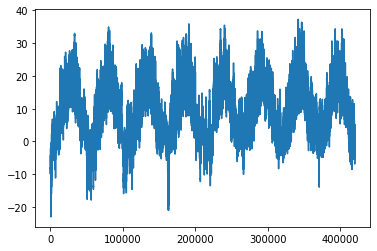

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

- 기온의 주기성
- 첫 10일간의 기온 데이터, 10분 간격으로 하루에 144개 관측치
- 일별 주기성, 일일 기온 변화가 크고, 시계열 데이터로 예측

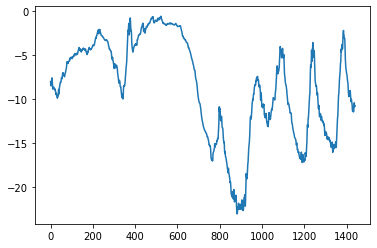

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 데이터 준비 및 전처리
- lookback 타임스텝(하나의 타임스텝은 10분) 지정, 이 만큼 이전으로 가서 샘플링, 24시간 delay후 기온 예측

 - lookback = 1440 : 10일 전 데이터로 돌아갑니다.
 - steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
 - delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

- 데이터 전처리: 값의 스케일링
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출
 - 모든 샘플을 각기 메모리에 올리는 것은 비효율적이어서, 필요 시 원본 데이터에서 배치를 생성
 - 각 값은 standard scaling
 - 전체 데이터 중 20만개 observation을 train으로 사용, 표준화 시 해당 범위 내 data로 평균 및 편차 계산

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
float_data = scaler.fit_transform(float_data)


- Sequence 제너레이터:(samples, targets) 튜플을 반복적으로 반환. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열
 - data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
 - lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
 - delay : 타깃으로 사용할 미래의 타임스텝
 - min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
 - shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정, 시간순서대로 사용
 - batch_size : 배치의 샘플 수
 - step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

- 데이터 파티셔닝
 - training: 20만개
 - validating: 그 다음 10만개
 - testing : 나머지

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

- 모형 성능 평가를 위해, 24시간 뒤 기온이 현재와 동일한 경우의 예측 성능을 MAE로 측정
 - MAE 계산:  np.mean(np.abs(preds - targets))
 
 - MSE(mean squared error)
 - RMSE(root MSE)
 - MAE
 - MAPE


In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.30448556213890343


 - MAE: 0.29 (평균0, 편차 1인 상황)
 - MAE X 표준편차: 2.57, 기온 예측 시 오차 정도

In [ ]:
0.30 * scaler.scale_[1]

0.3000000000000002

## 8. RNN 응용
- sequence 데이터로 반영: 시간 순서를 적용
- LSTM 과 GRU의 비교(RNN의 한 종류, LSTM의 단순화 버전)

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model1 = Sequential()
model1.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model1.add(layers.Dense(1))

model1.compile(optimizer=RMSprop(), loss='mae')
history1 = model1.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


50/50 [==============================] - 48s 900ms/step - loss: 0.3416 - val_loss: 0.5459
Epoch 2/5
50/50 [==============================] - 43s 880ms/step - loss: 0.3544 - val_loss: 0.4669
Epoch 3/5
50/50 [==============================] - 43s 883ms/step - loss: 0.4321 - val_loss: 0.4623
Epoch 4/5
50/50 [==============================] - 43s 877ms/step - loss: 0.3404 - val_loss: 0.5158
Epoch 5/5
50/50 [==============================] - 46s 938ms/step - loss: 0.3588 - val_loss: 0.5256


In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


50/50 [==============================] - 38s 737ms/step - loss: 0.4477 - val_loss: 0.5168
Epoch 2/5
50/50 [==============================] - 35s 712ms/step - loss: 0.3404 - val_loss: 0.4703
Epoch 3/5
50/50 [==============================] - 35s 715ms/step - loss: 0.3690 - val_loss: 0.4770
Epoch 5/5
50/50 [==============================] - 37s 749ms/step - loss: 0.3112 - val_loss: 0.4611


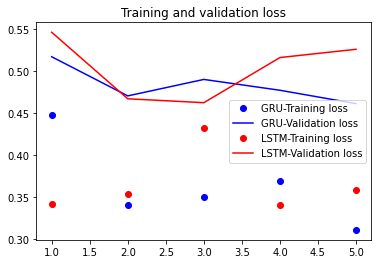

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='GRU-Training loss')
plt.plot(epochs, val_loss, 'b', label='GRU-Validation loss')

plt.plot(epochs, loss1, 'ro', label='LSTM-Training loss')
plt.plot(epochs, val_loss1, 'r', label='LSTM-Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

# 주가+RNN

## 1. 시계열 데이터에 대한 RNN 적용

In [ ]:
import pandas as pd
data=pd.read_csv('AMZN.csv', header=0,index_col="Date")
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2019-04-17 to 2020-04-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8+ KB


Open         High          Low        Close    Adj Close  \
count   252.000000   252.000000   252.000000   252.000000   252.000000   
mean   1864.800556  1883.242064  1846.651429  1866.393093  1866.393093   
std     110.513502   116.543016   110.148293   114.338644   114.338644   
min    1641.510010  1725.000000  1626.030029  1676.609985  1676.609985   
25%    1778.007507  1793.577515  1762.510040  1783.422516  1783.422516   
50%    1842.005005  1870.639954  1826.875000  1854.284973  1854.284973   
75%    1921.224945  1936.729981  1898.567535  1912.812469  1912.812469   
max    2346.000000  2461.000000  2335.000000  2408.189941  2408.189941   

             Volume  
count  2.520000e+02  
mean   4.060800e+06  
std    2.035731e+06  
min    8.813000e+05  
25%    2.748850e+06  
50%    3.410900e+06  
75%    4.754375e+06  
max    1.556730e+07

In [ ]:
print(data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-04-17  1872.989990  1876.469971  1860.439941  1864.819946  1864.819946   
2019-04-18  1868.790039  1870.819946  1859.479980  1861.689941  1861.689941   
2019-04-22  1855.400024  1888.420044  1845.640015  1887.310059  1887.310059   
2019-04-23  1891.199951  1929.260010  1889.579956  1923.770020  1923.770020   
2019-04-24  1925.000000  1929.689941  1898.160034  1901.750000  1901.750000   

             Volume  
Date                 
2019-04-17  2893500  
2019-04-18  2749900  
2019-04-22  3373800  
2019-04-23  4640400  
2019-04-24  3675800  


In [ ]:
data.shape

(252, 6)

In [ ]:
!pip install -U pykrx

from pykrx import stock

stock1 = stock.get_market_ticker_name("000660")
stock1

df = stock.get_market_ohlcv_by_date("20210104", "20211231", "005930")
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df
data=df

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


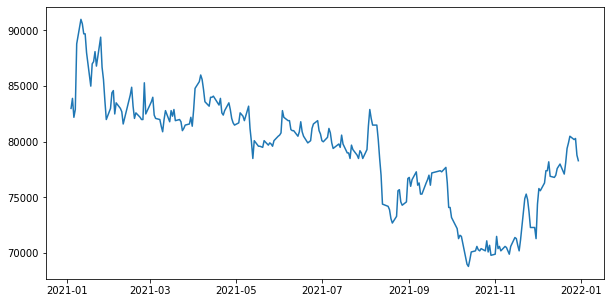

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(data['Close'])
plt.show()

- 정상성(Stationarity)
 - RNN이나 좋은 기법이라 하더라도 시계열 자료가 정상성이 결여된 경우 성능이 좋지 않을 수 있음
 - 정상성이란: 시계열 자료가 뚜렷한 트렌드 없이 값의 변동이 시간의 흐름에 따라 일정, stationarity
 - 정상성 여부의 검정: Dickey Fuller의 단위근 검정
  - 귀무가설: 비정상시계열 (단위근 있다)
  - 대립가설: 정상시계열(단위근 없다)

 - 비정상시계열인 경우: 시계열 자료 차분(differencing)하여 정상시계열로 변환 후 피팅

 - 주가: 일반적으로 비정상 시계열, 로그수익율인 경우 정상시계열이 됨
 - 수익율 = 현재 가격/과거 가격
 - 로그수익율: log현재가격-log과거가격 = log(현재가격/과거가격)


In [ ]:
#!pip install statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller    #종가의 정상성 여부 점검
result=adfuller(data['Close'])
print(result) #0.5933이 p-value, 비정상 시계열

(-1.8660739163103448, 0.34818538521662656, 0, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3830.8195835262513)


- acf, pacf
 - acf: 자기상관함수, autocorrelation function, k기간 떨어진 값들의 상관 계수
 - pacf: 편자기상관함수, partial autocorrelation function, 서로 다른 두 지점 사이의 관계를 분석할때, 중간에 있는 값들의 영향을 제외시킨 상관계수 

 - p가 증가 시, 지수적 감소 혹은 절단 형태여야 정상성, 둘 중 하나라도 느리게 감소하거나 증가 시 비정상성

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


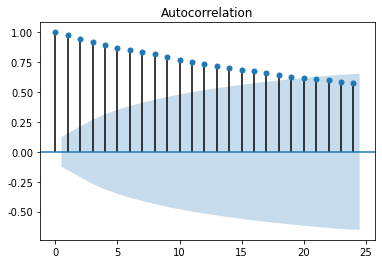

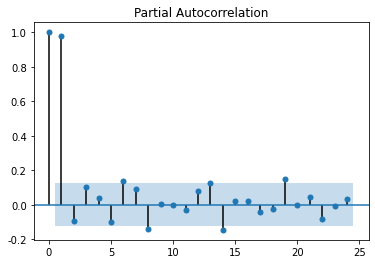

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close']) #느리게 감소, 비정상시계열
plot_pacf(data['Close'])
plt.show()

             Open        High         Low       Close      Volume
count  247.000000  247.000000  247.000000  247.000000  247.000000
mean    -0.000106   -0.000242   -0.000107   -0.000236   -0.004044
std      0.015147    0.013912    0.012226    0.013617    0.283487
min     -0.040052   -0.057402   -0.045330   -0.035591   -0.858579
25%     -0.007996   -0.007348   -0.006969   -0.007339   -0.185996
50%      0.000000    0.000000   -0.001219   -0.001234    0.002140
75%      0.007371    0.006873    0.005063    0.007221    0.176373
max      0.077361    0.072837    0.075398    0.068752    0.833300


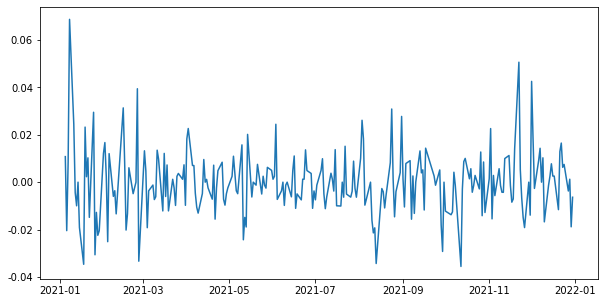

In [ ]:
import numpy as np
datapct=data.pct_change()
logreturn=np.log(1+datapct) #로그수익율
logreturn.head()
print(logreturn.describe())
plt.figure(figsize=(10,5))
plt.plot(logreturn['Close'])
plt.show()

In [ ]:
logreturn.dropna()

Open      High       Low     Close    Volume
날짜                                                          
2021-01-05  0.007380 -0.005942  0.017306  0.010785 -0.089790
2021-01-06  0.020619  0.007126  0.006109 -0.020470  0.174894
2021-01-07 -0.006020 -0.003557  0.007282  0.008480 -0.254106
2021-01-08  0.006020  0.066615  0.003621  0.068752  0.592082
2021-01-11  0.077361  0.072837  0.075398  0.024473  0.425443
...              ...       ...       ...       ...       ...
2021-12-24  0.005000  0.009950  0.011285  0.007481 -0.116335
2021-12-27  0.004975 -0.002478 -0.005000 -0.003734 -0.114074
2021-12-28 -0.004975 -0.002484 -0.001254  0.001246  0.524862
2021-12-29  0.000000 -0.002491 -0.015171 -0.018857  0.082552
2021-12-30 -0.016342 -0.008766 -0.005109 -0.006365 -0.329596

[247 rows x 5 columns]

In [ ]:
from statsmodels.tsa.stattools import adfuller
logreturn=logreturn.dropna()
result=adfuller(logreturn['Close']) #p-value < 0.05
print(result)

(-14.66805593110835, 3.3002349969433305e-27, 0, 246, {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}, -1365.2181452484738)


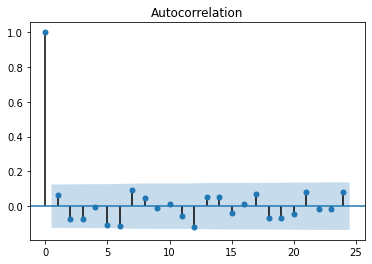

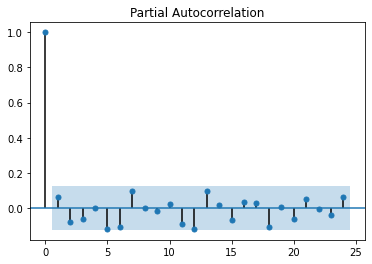

<class 'pandas.core.frame.DataFrame'>


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(logreturn['Close'])  
plot_pacf(logreturn['Close']) #그림에서 절단이 일어나는 위치를 p의 값으로 지정, 24?
plt.show()
print(type(logreturn))

In [ ]:
logr1=logreturn['Close'].values
print(type(logr1))
print(logr1.shape)
logr=logr1.reshape(1,-1)
print(logr.shape)
inte=13 #pacf의 p값
x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)
print(type(x))
print(type(y))
x=np.array(x)
y=np.array(y)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)
x_train=x[:210]
x_test=x[210:]
y_train=y[:210]
y_test=y[210:]

<class 'numpy.ndarray'>
(247,)
(1, 247)
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(234, 13)
(234,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
from tensorflow.keras import regularizers
model=Sequential()
model.add(Dense(1,input_shape=(inte,))) #p=24, AR(24)모형과 동일, 24개의 x변수를 갖는 셈.
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 1s 3ms/step - loss: 4.7297e-04 - mae: 0.0162
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 4.5227e-04 - mae: 0.0159
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 4.4185e-04 - mae: 0.0157
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 4.3570e-04 - mae: 0.0156
Epoch 5/30
7/7 [==============================] - 0s 5ms/step - loss: 4.2812e-04 - mae: 0.0154
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 4.2045e-04 - mae: 0.0154
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 4.1234e-04 - mae: 0.0152
Epoch 8/30
7/7 [==============================] - 0s 5ms/step - loss: 4.0829e-04 - mae: 0.0151
Epoch 9/30
7/7 [==============================] - 0s 7ms/step - loss: 3.9941e-04 - mae: 0.0150
Epoch 10/30
7/7 [==============================] - 0s 9ms/step - loss: 3.9152e-04 - mae: 0.0148
Epoch 11/30
7/7 [==============================] 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(inte,)))
model.add(Dense(1))                

model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 4ms/step - loss: 2.1972e-04 - mae: 0.0111
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 1.7942e-04 - mae: 0.0100
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5909e-04 - mae: 0.0095
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5434e-04 - mae: 0.0093
Epoch 5/30
7/7 [==============================] - 0s 6ms/step - loss: 1.5032e-04 - mae: 0.0092
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 1.4235e-04 - mae: 0.0090
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 1.4455e-04 - mae: 0.0093
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 1.3730e-04 - mae: 0.0090
Epoch 9/30
7/7 [==============================] - 0s 5ms/step - loss: 1.4449e-04 - mae: 0.0091
Epoch 10/30
7/7 [==============================] - 0s 6ms/step - loss: 1.2619e-04 - mae: 0.0084
Epoch 11/30
7/7 [==============================] 

In [ ]:
x_train=x_train.reshape(-1,1,inte)
x_test=x_test.reshape(-1,1,inte)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM  #(sample, timestep, features 형태의 데이터)
model=Sequential()
model.add(LSTM(32, input_shape=(1,inte)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 4ms/step - loss: 1.7582e-04 - mae: 0.0100
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 1.6565e-04 - mae: 0.0095
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 1.5885e-04 - mae: 0.0095
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 1.6368e-04 - mae: 0.0096
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5671e-04 - mae: 0.0095
Epoch 6/30
7/7 [==============================] - 0s 5ms/step - loss: 1.6270e-04 - mae: 0.0095
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5952e-04 - mae: 0.0095
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5509e-04 - mae: 0.0093
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 1.6026e-04 - mae: 0.0093
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5249e-04 - mae: 0.0092
Epoch 11/30
7/7 [==============================] 

In [ ]:
model=Sequential()
model.add(GRU(32, input_shape=(1,inte)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 5ms/step - loss: 2.4068e-04 - mae: 0.0118
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 1.8019e-04 - mae: 0.0101
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 1.6628e-04 - mae: 0.0096
Epoch 4/30
7/7 [==============================] - 0s 5ms/step - loss: 1.7183e-04 - mae: 0.0098
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 1.6975e-04 - mae: 0.0099
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 1.8300e-04 - mae: 0.0103
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5276e-04 - mae: 0.0092
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 1.6832e-04 - mae: 0.0097
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 1.5452e-04 - mae: 0.0093
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 1.6736e-04 - mae: 0.0098
Epoch 11/30
7/7 [==============================] 